<a href="https://colab.research.google.com/github/Sumedh-Kamat/test/blob/main/Analyzing_Market_Dynamics_and_Optimizing_Sales_Performance_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

Data Processing


In [ ]:
holidays_events_df = pd.read_csv("/content/holidays_events.csv")
oil_df = pd.read_csv("/content/oil.csv")
store_df = pd.read_csv("/content/stores.csv")
first_df = pd.read_csv("/content/train.csv")
transactions_df = pd.read_csv("/content/transactions.csv")

In [ ]:
clean_df = first_df.dropna()

print(clean_df.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [ ]:
clean_df['date'] = pd.to_datetime(clean_df['date'])

In [ ]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [ ]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [ ]:
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

In [ ]:
oil_df.rename(columns={'dcoilwtico': 'daily_oil_price'}, inplace=True)

In [ ]:
clean_df['store_nbr'] = clean_df['store_nbr'].astype(int)

In [ ]:
# Check for duplicate rows
duplicate_rows = clean_df[clean_df.duplicated()]

# Display duplicate rows (if any)
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


EDA Visualization

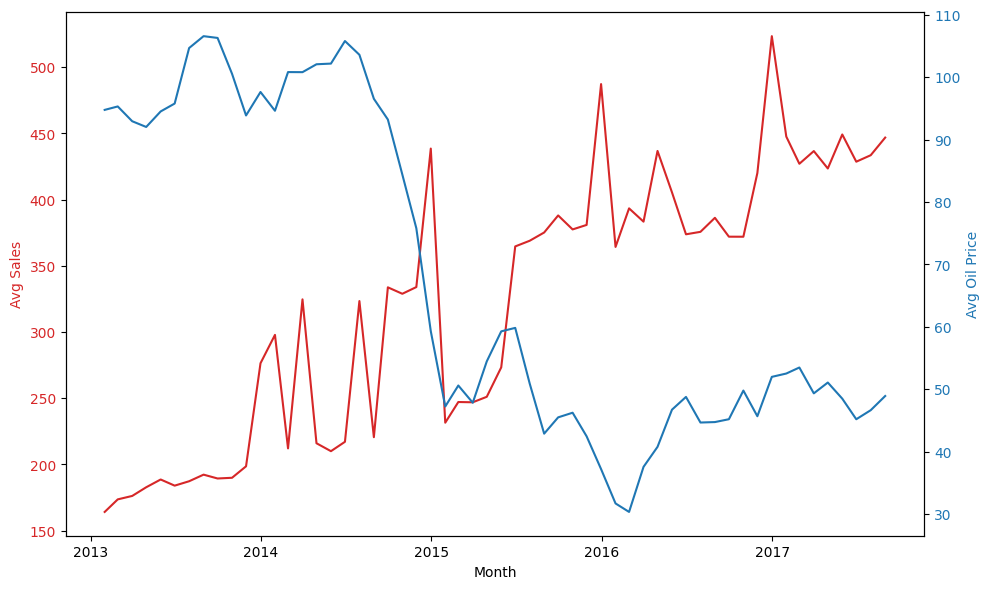

In [ ]:
# Merge clean_df and oil_df on 'date'
merged_df = pd.merge(clean_df, oil_df, on='date')

# Calculate average sales revenue per day
daily_avg_sales = merged_df.groupby('date')['sales'].mean()

# Group by month and calculate average sales revenue per month
monthly_avg_sales = daily_avg_sales.resample('M').mean()

# Group oil prices by month and calculate average oil price per month
monthly_avg_oil_price = merged_df.groupby(pd.Grouper(key='date', freq='M'))['daily_oil_price'].mean()

# Plot average oil prices and average sales revenue by month
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Sales', color=color)
ax1.plot(monthly_avg_sales.index, monthly_avg_sales.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Oil Price', color=color)
ax2.plot(monthly_avg_oil_price.index, monthly_avg_oil_price.values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
#plt.title('Average Sales vs Average Oil Price by Month')
plt.show()

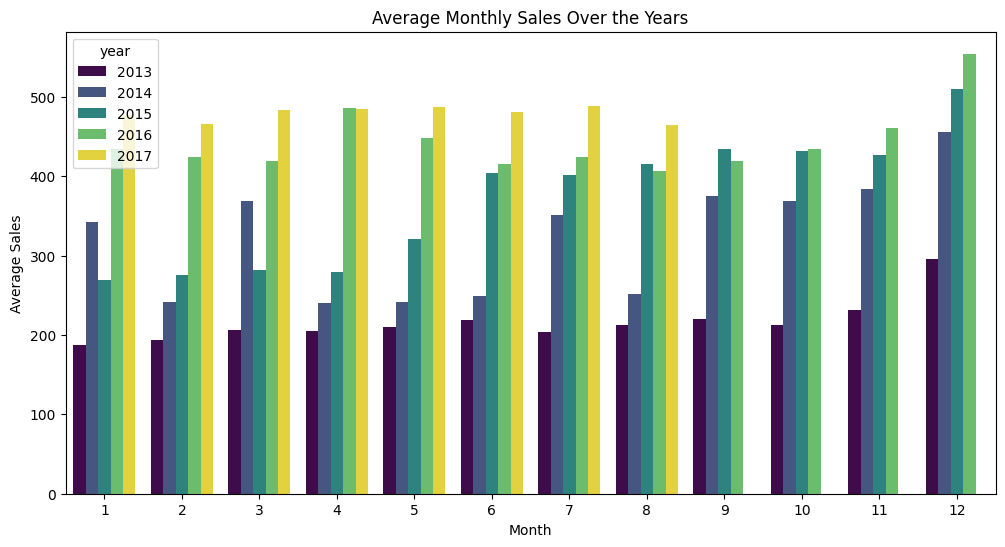

In [ ]:
# Extract month and year information
clean_df['month'] = clean_df['date'].dt.month
clean_df['year'] = clean_df['date'].dt.year

# Group by month and year, calculate average sales
monthly_avg_sales = clean_df.groupby(['year', 'month'])['sales'].mean().reset_index()

# Create a bar chart using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='sales', hue='year', data=monthly_avg_sales, palette='viridis')
plt.title('Average Monthly Sales Over the Years')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

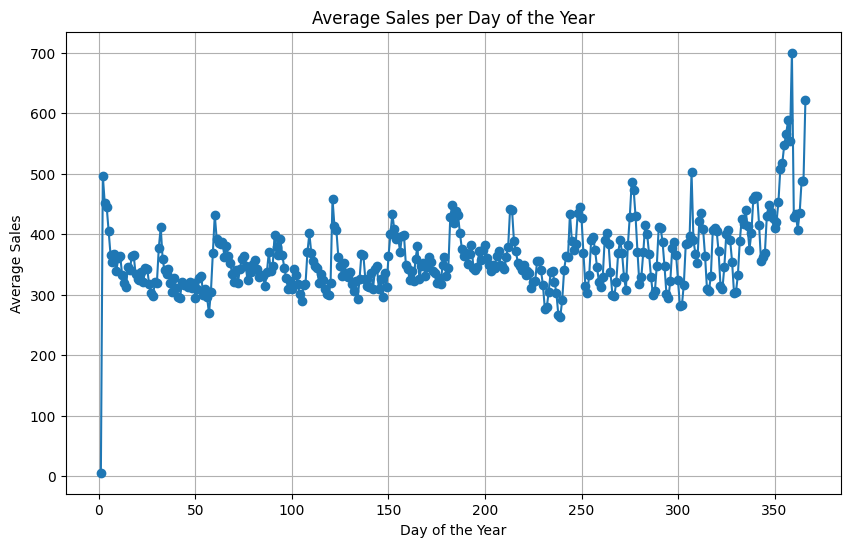

In [ ]:
# Group dates by day and calculate average sales per day
daily_avg_sales = clean_df.groupby(clean_df['date'].dt.dayofyear)['sales'].mean()

# Plot average sales for each day of the year
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales.values, marker='o', linestyle='-')
plt.title('Average Sales per Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

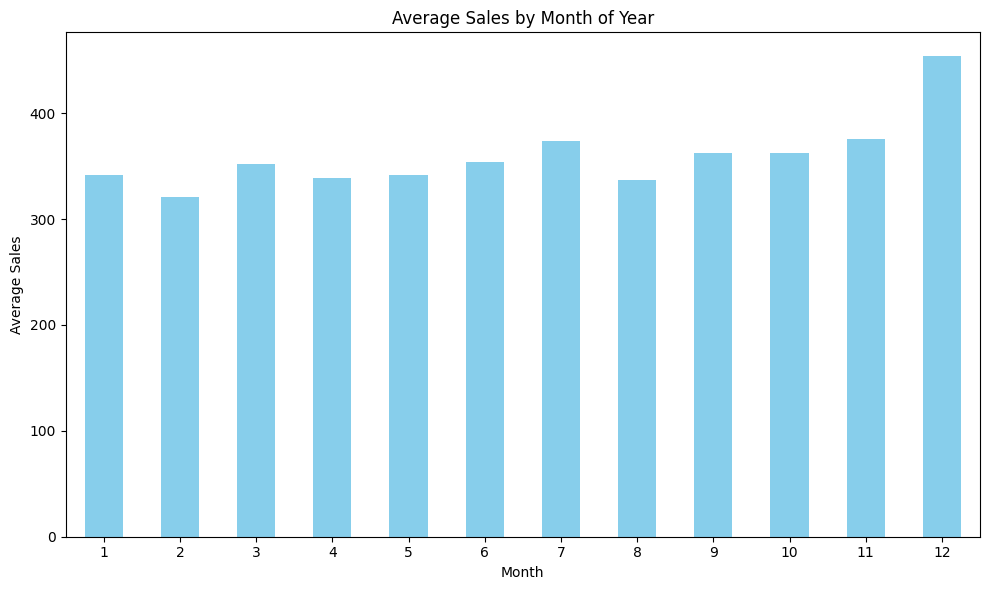

In [ ]:
# Extract month from the 'date' column
clean_df['month'] = clean_df['date'].dt.month

# Group by month and calculate average sales
avg_sales_by_month = clean_df.groupby('month')['sales'].mean()

# Plot average sales by month
plt.figure(figsize=(10, 6))
avg_sales_by_month.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Month of Year')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)  # Rotate x-axis labels to avoid overlapping
plt.tight_layout()
plt.show()

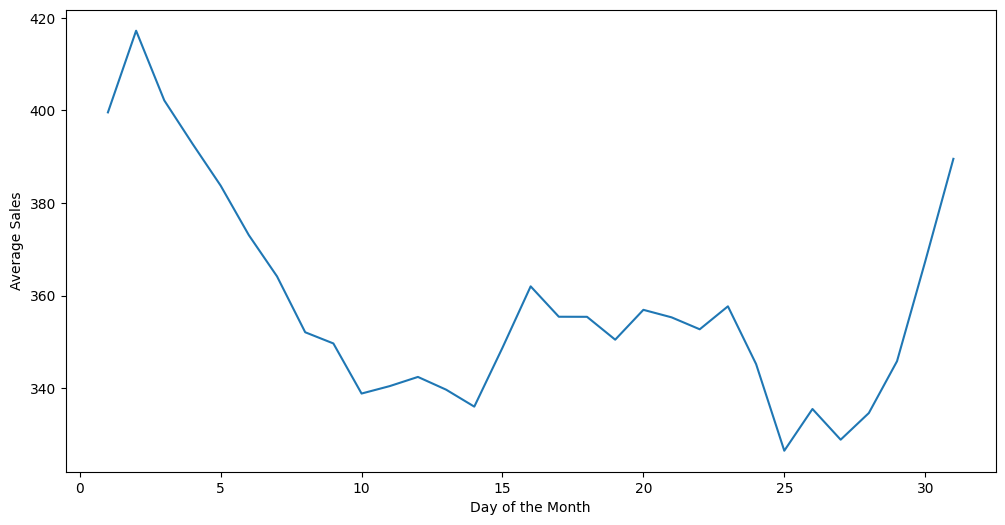

In [ ]:
# Extract day of the month from the 'date' column
clean_df['day_of_month'] = clean_df['date'].dt.day

# Group by day of the month, calculate average sales
daily_avg_sales = clean_df.groupby('day_of_month')['sales'].mean().reset_index()

# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_month', y='sales', data=daily_avg_sales)
#plt.title('Average Sales for Each Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Sales')
plt.show()

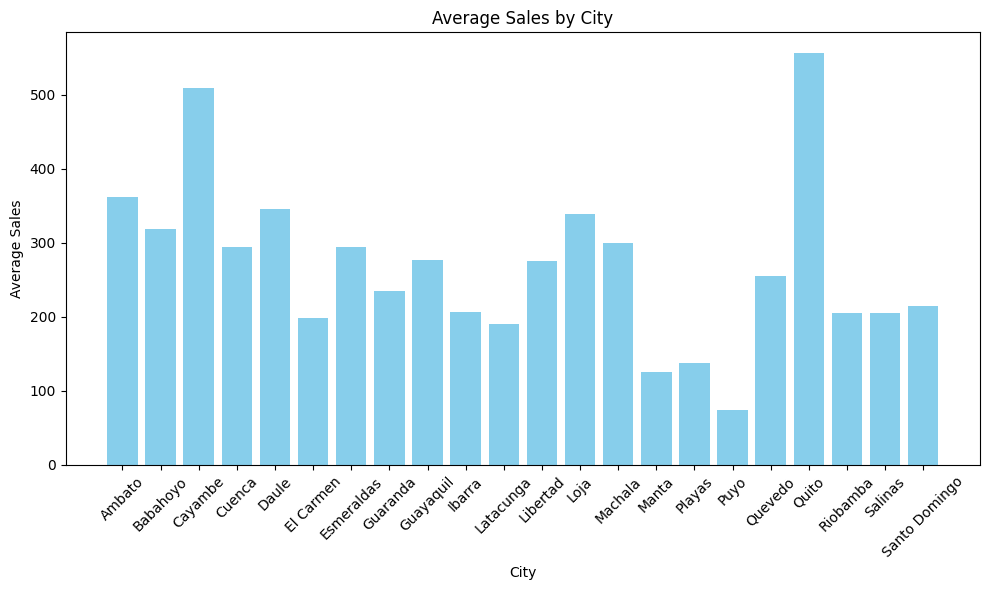

In [ ]:
# Merge store_df with clean_df by store_nbr
merged_df = pd.merge(clean_df, store_df, on='store_nbr', how='left')

# Group by city and calculate average sales per city
city_avg_sales = merged_df.groupby('city')['sales'].mean().reset_index()

# Plot average sales per city as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(city_avg_sales['city'], city_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Feature Engineering + Dataset Preparation

In [ ]:
holidays_list = holidays_events_df['date'].tolist()
holidays_list = pd.to_datetime(holidays_list)

In [ ]:
# Create a new column 'is_holiday' to identify if a date is a holiday
clean_df['is_holiday'] = clean_df['date'].isin(holidays_events_df['date'])

# Filter rows where the date is not a holiday and keep only unique dates
not_holidays_df = clean_df[~clean_df['is_holiday']].drop_duplicates('date').copy()

# Convert 'date' column to datetime format
not_holidays_df['date'] = pd.to_datetime(not_holidays_df['date'])

# Sort the dataframe by date for better calculation
not_holidays_df = not_holidays_df.sort_values(by='date')

# Update is_holiday based on transferred holidays
for index, row in holidays_events_df[holidays_events_df['type'] == 'Transfer'].iterrows():
    transferred_date = row['date']
    holiday_name = row['description']
    actual_date_df = holidays_events_df[(holidays_events_df['description'] == holiday_name) & (holidays_events_df['type'] == 'Holiday')]
    if not actual_date_df.empty:
        actual_date = actual_date_df['date'].values[0]
        not_holidays_df.loc[not_holidays_df['date'] == actual_date, 'is_holiday'] = True

# Calculate the days till the next upcoming holiday
not_holidays_df['days_till_holiday'] = (
    not_holidays_df['date'].shift(-1) - not_holidays_df['date']
).dt.days

# Replace the days_till_holiday with NaN for rows where the date is already a holiday
not_holidays_df.loc[not_holidays_df['is_holiday'], 'days_till_holiday'] = pd.NaT

# Drop the unnecessary columns
not_holidays_df = not_holidays_df[['date', 'days_till_holiday']]

# Reset the index if needed
not_holidays_df.reset_index(drop=True, inplace=True)

# Display the resulting dataframe
not_holidays_df.head()


,date,days_till_holiday
0,2013-01-02,1.0
1,2013-01-03,1.0
2,2013-01-04,2.0
3,2013-01-06,1.0
4,2013-01-07,1.0


In [ ]:
store_df.drop(['type', 'cluster'], axis=1, inplace=True)
store_df.head()

,store_nbr,city,state
0,1,Quito,Pichincha
1,2,Quito,Pichincha
2,3,Quito,Pichincha
3,4,Quito,Pichincha
4,5,Santo Domingo,Santo Domingo de los Tsachilas


In [ ]:
new_df = pd.merge(clean_df, oil_df, on='date', how='left')

new_df = pd.merge(new_df, store_df, on='store_nbr', how='left')

new_df = pd.merge(new_df, holidays_events_df, on=['date'], how='left')

new_df = pd.merge(new_df, transactions_df, on=['store_nbr','date'], how='left')

new_df = pd.merge(new_df, not_holidays_df, on=['date'], how='left')

In [ ]:
new_df.drop(['locale','locale_name','description',	'transferred','type'	], axis=1, inplace=True)

In [ ]:
new_df.rename(columns={'sales': 'family_sales'}, inplace=True)

In [ ]:
# Step 1: Group by 'date' and 'store_nbr' and sum the 'family_sales' for each date and store_nbr
sales_per_date_store = new_df.groupby(['date', 'store_nbr'])['family_sales'].sum().reset_index()

# Step 2: Rename the sum column to 'sales'
sales_per_date_store.rename(columns={'family_sales': 'sales'}, inplace=True)

# Step 3: Merge the original DataFrame with the aggregated sales_per_date DataFrame
new_df = pd.merge(new_df, sales_per_date_store, on=['date', 'store_nbr'], how='left')

# Step 4: Drop the 'family' and 'family_sales' columns
new_df.drop(['family', 'family_sales'], axis=1, inplace=True)

In [ ]:
new_df.drop(['id', 'onpromotion'], axis=1, inplace=True)

In [ ]:
total_df = new_df.drop_duplicates()

In [ ]:
total_df.reset_index(drop=True, inplace=True)

In [ ]:
# Drop the entries where sales are equal to 0
total_df = total_df[total_df['sales'] != 0]

# Reset index after dropping rows
total_df.reset_index(drop=True, inplace=True)

Import Geographic Features

In [ ]:
# Dictionary to map Ecuadorian states to regions and identify coastal states
state_info = {
    'Pichincha': {'region': 'North', 'is_coastal': False},
    'Cotopaxi': {'region': 'Central', 'is_coastal': False},
    'Chimborazo': {'region': 'Central', 'is_coastal': False},
    'Imbabura': {'region': 'North', 'is_coastal': False},
    'Santo Domingo de los Tsachilas': {'region': 'West', 'is_coastal': False},
    'Bolivar': {'region': 'Central', 'is_coastal': False},
    'Pastaza': {'region': 'East', 'is_coastal': False},
    'Tungurahua': {'region': 'Central', 'is_coastal': False},
    'Guayas': {'region': 'West', 'is_coastal': True},
    'Santa Elena': {'region': 'West', 'is_coastal': True},
    'Los Rios': {'region': 'Central', 'is_coastal': True},
    'Azuay': {'region': 'South', 'is_coastal': False},
    'Loja': {'region': 'South', 'is_coastal': False},
    'El Oro': {'region': 'South', 'is_coastal': True},
    'Esmeraldas': {'region': 'West', 'is_coastal': True},
    'Manabi': {'region': 'West', 'is_coastal': True}
}

# Map states to regions and identify coastal states in total_df
total_df['region'] = total_df['state'].map(lambda x: state_info[x]['region'] if x in state_info else None)
total_df['is_coastal'] = total_df['state'].map(lambda x: state_info[x]['is_coastal'] if x in state_info else None)


In [ ]:
# Define a dictionary mapping cities to their corresponding locations
city_location_mapping = {
    'Quito': 'urban',
    'Cayambe': 'rural',
    'Latacunga': 'rural',
    'Riobamba': 'rural',
    'Ibarra': 'rural',
    'Santo Domingo': 'urban',
    'Guaranda': 'rural',
    'Puyo': 'rural',
    'Ambato': 'urban',
    'Guayaquil': 'urban',
    'Salinas': 'urban',
    'Daule': 'urban',
    'Babahoyo': 'urban',
    'Quevedo': 'urban',
    'Playas': 'urban',
    'Libertad': 'urban',
    'Cuenca': 'urban',
    'Loja': 'urban',
    'Machala': 'urban',
    'Esmeraldas': 'urban',
    'Manta': 'urban',
    'El Carmen': 'urban'
}

# Map the cities to their corresponding locations using the dictionary
total_df['location'] = total_df['city'].map(city_location_mapping)

In [ ]:
altitude_data_ft = {
    'Quito': 9350,
    'Cayambe': 18996,
    'Latacunga': 9055,
    'Riobamba': 9035,
    'Ibarra': 7300,
    'Santo Domingo': 2051,
    'Guaranda': 8753,
    'Puyo': 3116,
    'Ambato': 8455,
    'Guayaquil': 13,
    'Salinas': 12588,
    'Daule': 88,
    'Babahoyo': 26,
    'Quevedo': 243,
    'Playas': 476.25,
    'Libertad': 92,
    'Cuenca': 8517,
    'Loja': 6889,
    'Machala': 20,
    'Esmeraldas': 49,
    'Manta': 20,
    'El Carmen': 960
}

total_df['city_altitude'] = total_df['city'].map(altitude_data_ft)

Import Economic Data

In [ ]:
# GDP growth data
gdp_growth_data = {
    2013: 4.9,
    2014: 3.8,
    2015: 0.1,
    2016: -1.2,
    2017: 2.4,
}

# Convert date column to datetime format
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract year from the date column
total_df['year'] = total_df['date'].dt.year

# Add GDP growth data to total_df
total_df['ecuador_gdp_growth'] = total_df['year'].map(gdp_growth_data)

In [ ]:
# Create a dictionary to map years to their corresponding inflation rates
inflation_rates = {
    2013: 2.7,
    2014: 3.6,
    2015: 4.0,
    2016: 1.7,
    2017: 0.4,
}

# Convert the 'date' column to datetime format to extract the year
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Map the inflation rates to the corresponding years
total_df['ecuador_inflation_rate'] = total_df['year'].map(inflation_rates)

In [ ]:
# Define the labor force data
labor_force_data = {
    2013: 6857058,
    2014: 7045425,
    2015: 7548658,
    2016: 7951902,
    2017: 8190955
}

# Map the labor force data to the 'year' column in total_df
total_df['ecuador_labor_force'] = total_df['year'].map(labor_force_data)

In [ ]:
unemployment_rate = {
    2013: 3.1,
    2014: 3.5,
    2015: 3.6,
    2016: 4.6,
    2017: 3.8,
}

total_df['ecuador_unemployment_rate'] = total_df['year'].map(unemployment_rate)

In [ ]:
dependency_ratio = {
    2013: 56.8,
    2014: 56.2,
    2015: 55.5,
    2016: 54.7,
    2017: 54.0,
}

total_df['ecuador_dependency_ratio'] = total_df['year'].map(dependency_ratio)

In [ ]:
consumer_price_index = {
    2013: 112.8,
    2014: 116.8,
    2015: 121.5,
    2016: 123.6,
    2017: 124.1
}

total_df['ecuador_cpi'] = total_df['year'].map(consumer_price_index)

In [ ]:
median_age = {
    2013: 24.7252,
    2014: 25.0635,
    2015: 25.4162,
    2016: 25.7791,
    2017: 26.1466,
}

total_df['ecuador_median_age'] = total_df['year'].map(median_age)

Add Seasonality

In [ ]:
# Define a function to map months to seasons
def get_season(month):
    if month in [10, 11, 12, 1, 2, 3, 4, 5]:
        return 'dry'
    elif month in [6, 7, 8, 9]:
        return 'rainy'

# Add a new 'season' column to total_df
total_df['ecuador_season'] = total_df['month'].apply(get_season)

In [ ]:
total_df['is_2016'] = total_df['year'] == 2016

Add Weekend Indicator

In [ ]:
# Define a function to check if a given day of the week is a weekend
def is_weekend(day_of_week):
    return day_of_week in ['Friday', 'Saturday', 'Sunday']

# Map day of the week to each date
day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
total_df['day_of_week'] = total_df['date'].dt.dayofweek.map(day_of_week_map)

# Add the is_weekend feature based on the day of the week
total_df['is_weekend'] = total_df['day_of_week'].apply(is_weekend)

Fill Null Values with Interpolation

In [ ]:
# 1. Interpolate missing daily_oil_price data using polynomial interpolation
total_df['new_oil_price_data'] = total_df['daily_oil_price'].interpolate(method='polynomial', order=2)

# 2. Substitute new_oil_price_data entries in the original daily_oil_price data only where it is null
total_df['daily_oil_price'] = total_df['daily_oil_price'].where(total_df['daily_oil_price'].notna(), total_df['new_oil_price_data'])

# 3. Drop new_oil_price_data
total_df.drop(columns=['new_oil_price_data'], inplace=True)

total_df['daily_oil_price'].fillna(method='bfill', inplace=True)

In [ ]:
# Interpolate missing transactions data into a new column using linear interpolation
total_df['new_transactions_data'] = total_df['transactions'].interpolate(method='linear')

# Substitute new transactions data entries into the original transactions data only where it is null
total_df['transactions'] = total_df['transactions'].fillna(total_df['new_transactions_data'])

# Drop the new_transactions_data column
total_df.drop(columns=['new_transactions_data'], inplace=True)

total_df['transactions'].fillna(method='bfill', inplace=True)

In [ ]:
# Fill null values in the 'days_till_holiday' column with 0
total_df['days_till_holiday'].fillna(0, inplace=True)

In [ ]:
# Calculate the percentage of null values for each column
null_percentage = (total_df.isnull().sum() / len(total_df)) * 100

# Print the percentage of null values for each column
print("Percentage of null values for each column:")
print(null_percentage)

Percentage of null values for each column:
date                         0.0
store_nbr                    0.0
month                        0.0
year                         0.0
day_of_week                  0.0
day_of_month                 0.0
is_holiday                   0.0
daily_oil_price              0.0
city                         0.0
state                        0.0
transactions                 0.0
days_till_holiday            0.0
sales                        0.0
region                       0.0
is_coastal                   0.0
location                     0.0
city_altitude                0.0
ecuador_gdp_growth           0.0
ecuador_inflation_rate       0.0
ecuador_labor_force          0.0
ecuador_unemployment_rate    0.0
ecuador_dependency_ratio     0.0
ecuador_cpi                  0.0
ecuador_median_age           0.0
ecuador_season               0.0
is_2016                      0.0
is_weekend                   0.0
dtype: float64


In [ ]:
total_df

,date,store_nbr,month,year,day_of_week,day_of_month,is_holiday,daily_oil_price,city,state,...,ecuador_gdp_growth,ecuador_inflation_rate,ecuador_labor_force,ecuador_unemployment_rate,ecuador_dependency_ratio,ecuador_cpi,ecuador_median_age,ecuador_season,is_2016,is_weekend
0,2013-01-01,25,1,2013,Tuesday,1,True,93.14,Salinas,Santa Elena,...,4.9,2.7,6857058,3.1,56.8,112.8,24.7252,dry,False,False
1,2013-01-02,1,1,2013,Wednesday,2,False,93.14,Quito,Pichincha,...,4.9,2.7,6857058,3.1,56.8,112.8,24.7252,dry,False,False
2,2013-01-02,10,1,2013,Wednesday,2,False,93.14,Quito,Pichincha,...,4.9,2.7,6857058,3.1,56.8,112.8,24.7252,dry,False,False
3,2013-01-02,11,1,2013,Wednesday,2,False,93.14,Cayambe,Pichincha,...,4.9,2.7,6857058,3.1,56.8,112.8,24.7252,dry,False,False
4,2013-01-02,12,1,2013,Wednesday,2,False,93.14,Latacunga,Cotopaxi,...,4.9,2.7,6857058,3.1,56.8,112.8,24.7252,dry,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83601,2017-08-15,54,8,2017,Tuesday,15,True,47.57,El Carmen,Manabi,...,2.4,0.4,8190955,3.8,54.0,124.1,26.1466,rainy,False,False
83602,2017-08-15,6,8,2017,Tuesday,15,True,47.57,Quito,Pichincha,...,2.4,0.4,8190955,3.8,54.0,124.1,26.1466,rainy,False,False
83603,2017-08-15,7,8,2017,Tuesday,15,True,47.57,Quito,Pichincha,...,2.4,0.4,8190955,3.8,54.0,124.1,26.1466,rainy,False,False
83604,2017-08-15,8,8,2017,Tuesday,15,True,47.57,Quito,Pichincha,...,2.4,0.4,8190955,3.8,54.0,124.1,26.1466,rainy,False,False


Engineered Features Visualization

<Figure size 1200x800 with 0 Axes>

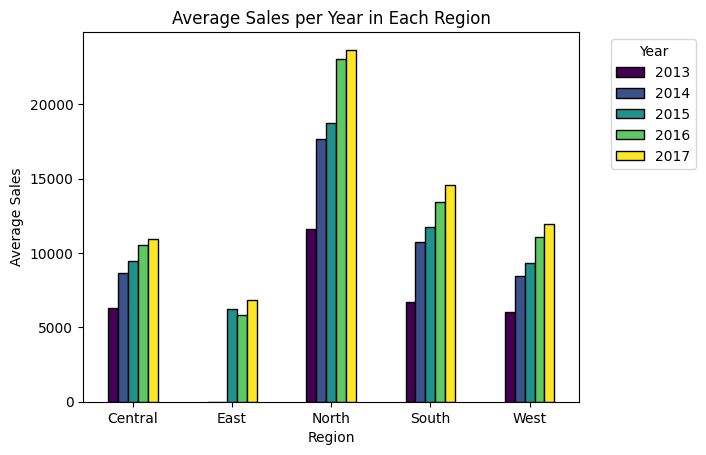

In [ ]:
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Group by region and year, calculate the average sales
avg_sales_per_year_region = total_df.groupby(['region', 'year'])['sales'].mean().unstack()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
avg_sales_per_year_region.plot(kind='bar', cmap='viridis', edgecolor='black')

plt.title('Average Sales per Year in Each Region')
plt.xlabel('Region')
plt.ylabel('Average Sales')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

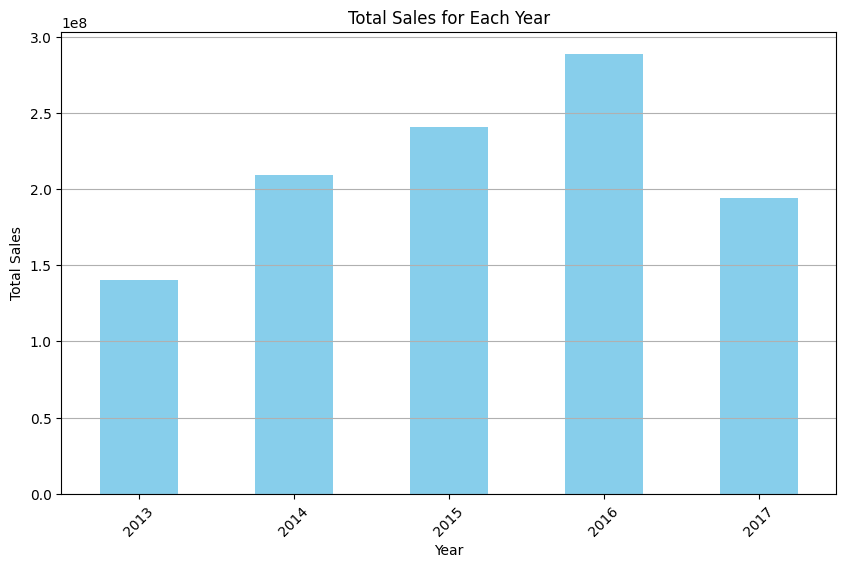

In [ ]:
# Extract year from the 'date' column
clean_df['year'] = clean_df['date'].dt.year

# Group by year and calculate total sales
yearly_sales = clean_df.groupby('year')['sales'].sum()

# Plot total sales for each year
plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

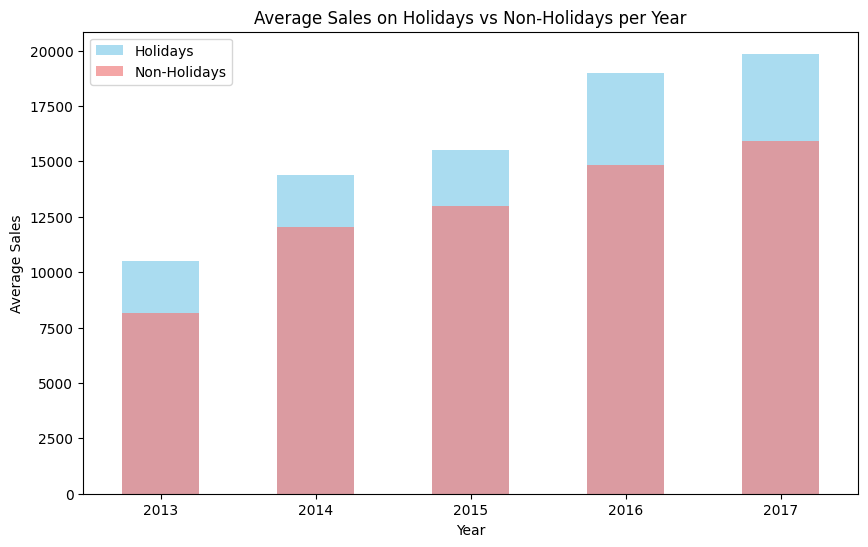

In [ ]:
# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Filter DataFrame for holidays and non-holidays
holidays_df = total_df[total_df['is_holiday'] == True]
non_holidays_df = total_df[total_df['is_holiday'] == False]

# Calculate average sales per year for holidays and non-holidays
avg_sales_holidays = holidays_df.groupby('year')['sales'].mean()
avg_sales_non_holidays = non_holidays_df.groupby('year')['sales'].mean()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
avg_sales_holidays.plot(kind='bar', color='skyblue', label='Holidays', alpha=0.7)
avg_sales_non_holidays.plot(kind='bar', color='lightcoral', label='Non-Holidays', alpha=0.7)

plt.title('Average Sales on Holidays vs Non-Holidays per Year')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.legend()
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

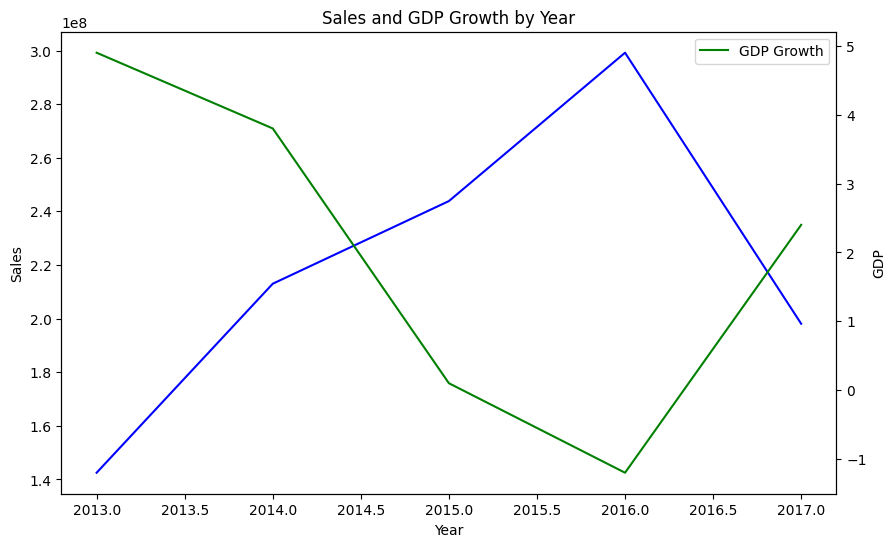

In [ ]:
# Group sales and Ecuador GDP by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
gdp_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_gdp_growth'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for GDP
plt.twinx()
plt.plot(gdp_by_year.index, gdp_by_year.values, label='GDP Growth', color='green')
plt.ylabel('GDP')

# Add title and legend
plt.title('Sales and GDP Growth by Year')
plt.legend()

plt.show()

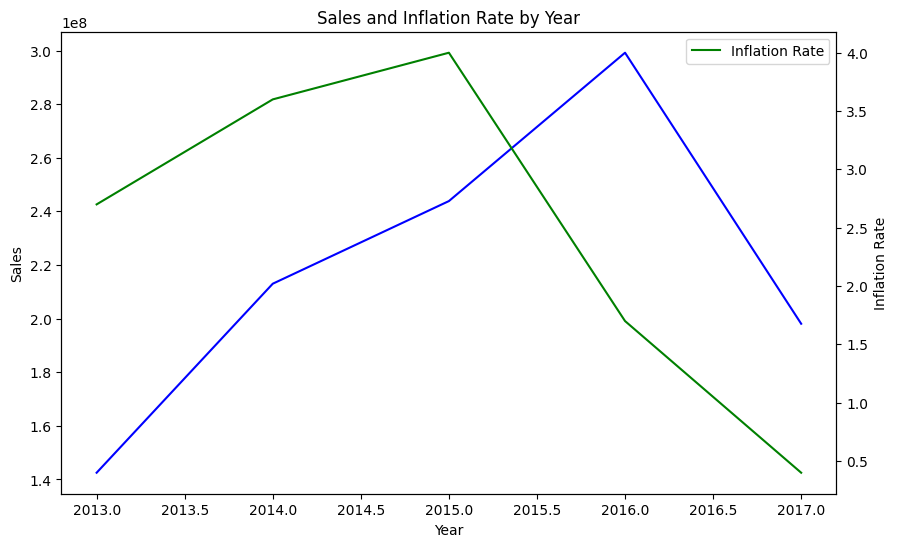

In [ ]:
# Group sales and Ecuador Inflation by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
inflation_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_inflation_rate'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Inflation
plt.twinx()
plt.plot(inflation_by_year.index, inflation_by_year.values, label='Inflation Rate', color='green')
plt.ylabel('Inflation Rate')

# Add title and legend
plt.title('Sales and Inflation Rate by Year')
plt.legend()

plt.show()

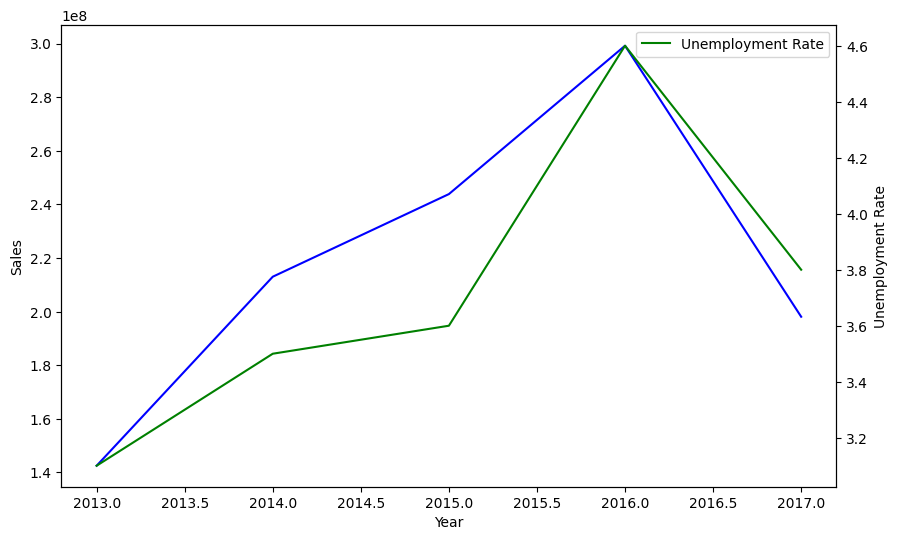

In [ ]:
# Group sales and Ecuador Unemployment Rates by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
unemployment_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_unemployment_rate'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Unemployment Rates
plt.twinx()
plt.plot(unemployment_by_year.index, unemployment_by_year.values, label='Unemployment Rate', color='green')
plt.ylabel('Unemployment Rate')

# Add title and legend
#plt.title('Sales and Unemployment Rate by Year')
plt.legend()

plt.show()

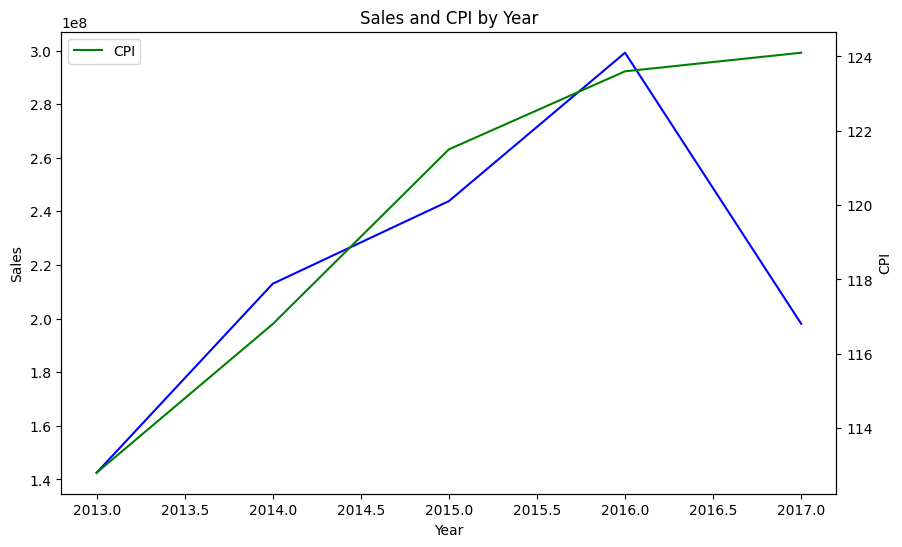

In [ ]:
# Group sales and Ecuador CPI by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
cpi_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_cpi'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for CPI
plt.twinx()
plt.plot(cpi_by_year.index, cpi_by_year.values, label='CPI', color='green')
plt.ylabel('CPI')

# Add title and legend
plt.title('Sales and CPI by Year')
plt.legend()

plt.show()

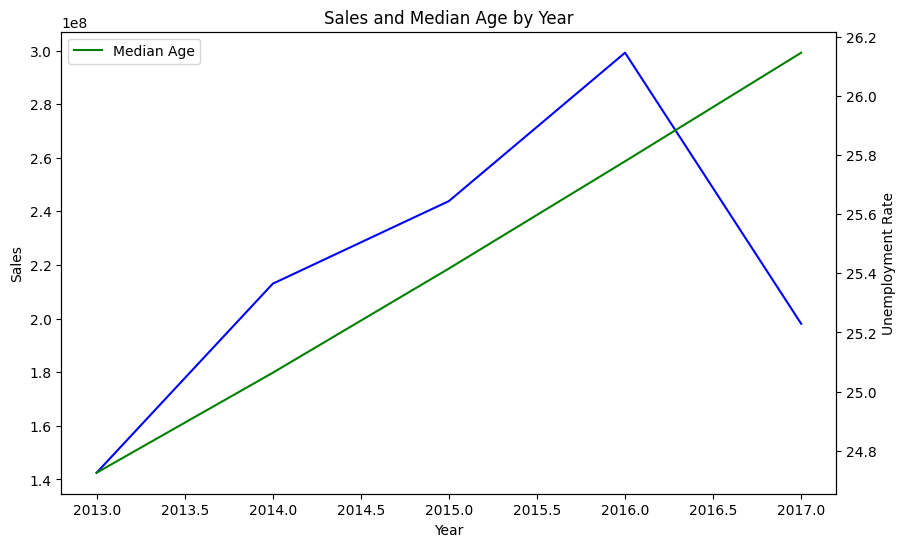

In [ ]:
# Group sales and Ecuador median age by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
median_age_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_median_age'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Median Age
plt.twinx()
plt.plot(median_age_by_year.index, median_age_by_year.values, label='Median Age', color='green')
plt.ylabel('Unemployment Rate')

# Add title and legend
plt.title('Sales and Median Age by Year')
plt.legend()

plt.show()

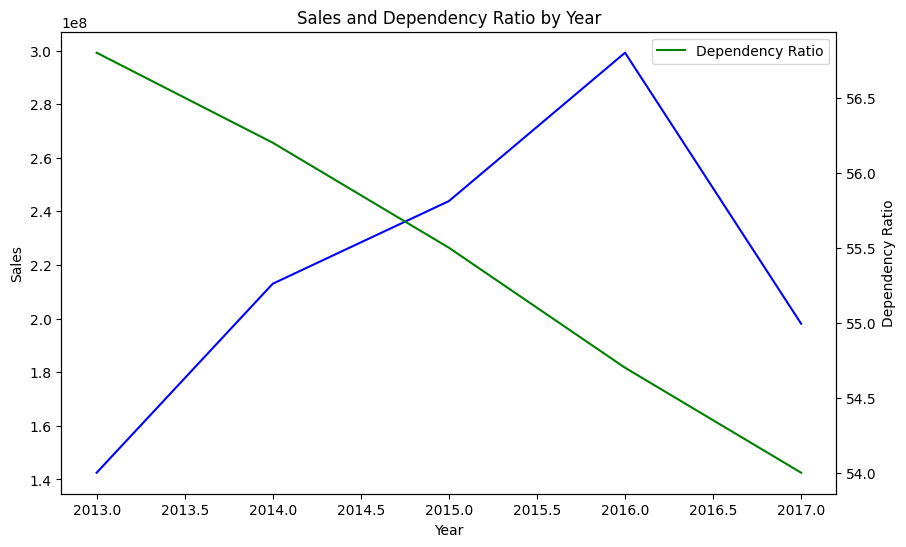

In [ ]:
# Group sales and Ecuador dependency ratio by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
dependency_ratio_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_dependency_ratio'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for dependency ratio
plt.twinx()
plt.plot(dependency_ratio_by_year.index, dependency_ratio_by_year.values, label='Dependency Ratio', color='green')
plt.ylabel('Dependency Ratio')

# Add title and legend
plt.title('Sales and Dependency Ratio by Year')
plt.legend()

plt.show()

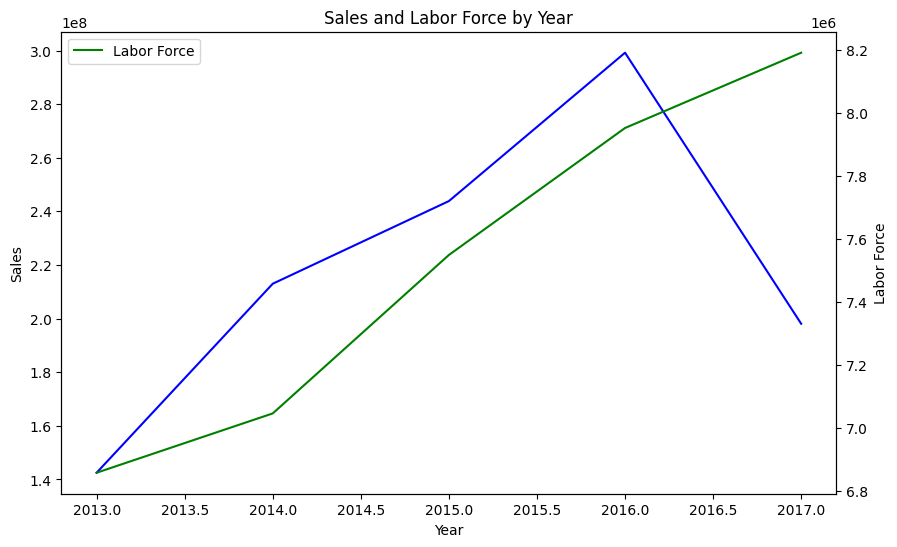

In [ ]:
# Group sales and labor force by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
labor_force_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_labor_force'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for labor force
plt.twinx()
plt.plot(labor_force_by_year.index, labor_force_by_year.values, label='Labor Force', color='green')
plt.ylabel('Labor Force')

# Add title and legend
plt.title('Sales and Labor Force by Year')
plt.legend()

plt.show()

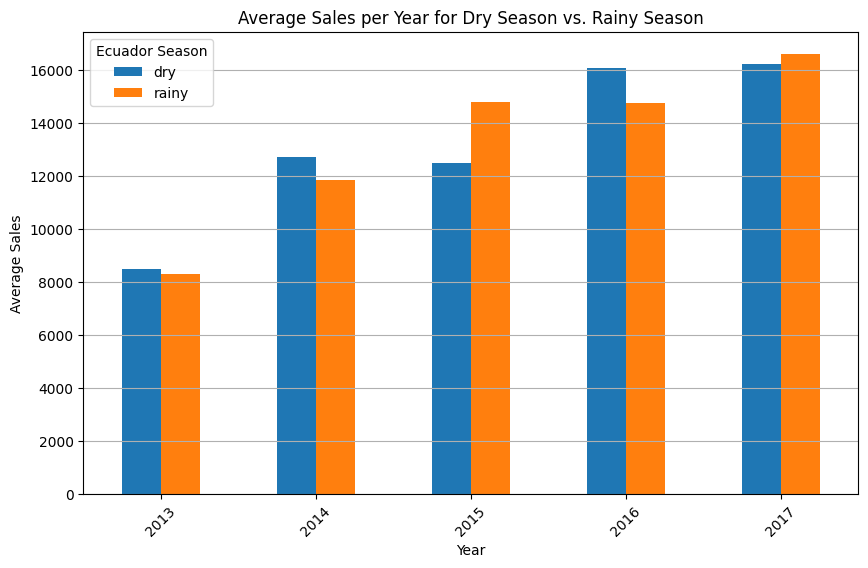

In [ ]:
# Group sales by year and 'ecuador_season', and calculate the average sales
sales_by_season = total_df.groupby([total_df['date'].dt.year, 'ecuador_season'])['sales'].mean().unstack()

# Plot average sales per year for dry season and rainy season
sales_by_season.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Dry Season vs. Rainy Season')
plt.legend(title='Ecuador Season')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

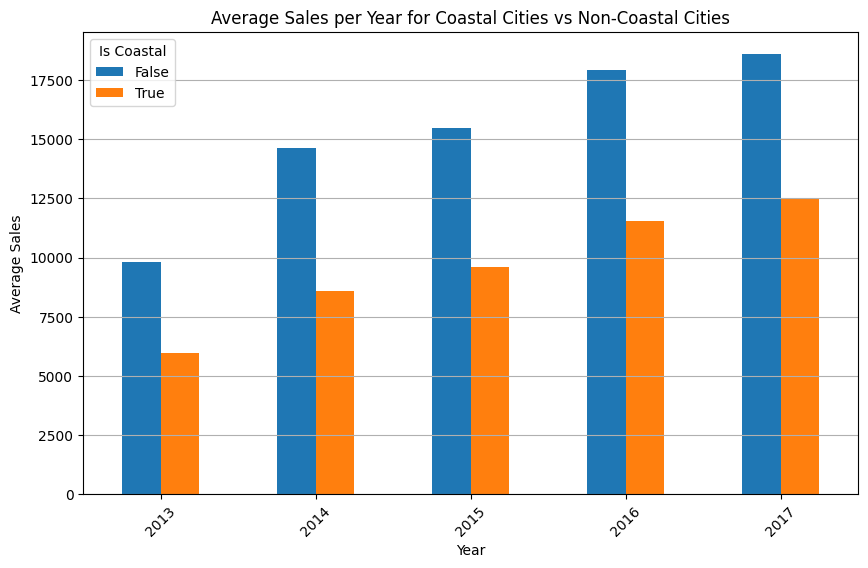

In [ ]:
# Group sales by year and is_coastal, calculate average sales
sales_by_coastal = total_df.groupby([total_df['date'].dt.year, 'is_coastal'])['sales'].mean().unstack()

# Plot average sales per year for coastal and non-coastal cities
sales_by_coastal.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Coastal Cities vs Non-Coastal Cities')
plt.legend(title='Is Coastal')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

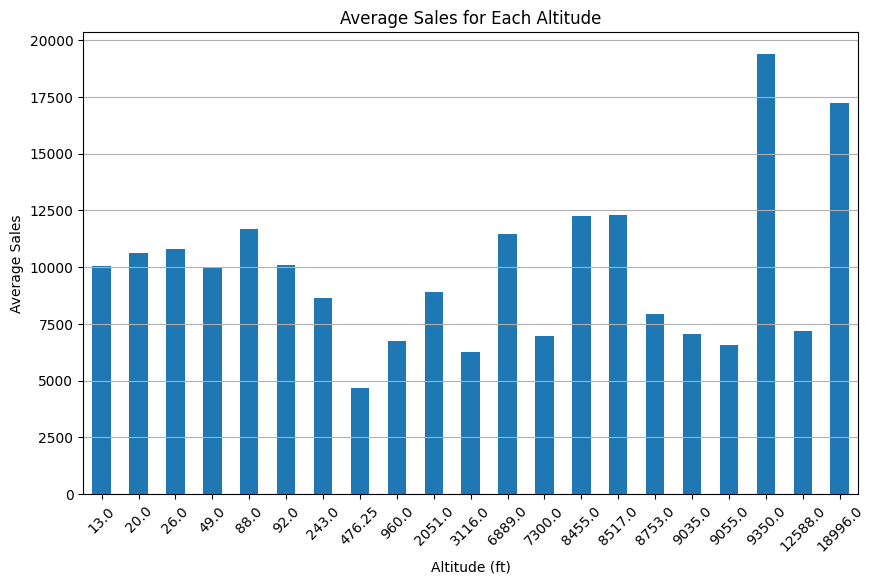

In [ ]:
# Group sales by city and calculate average sales
sales_by_city = total_df.groupby('city')['sales'].mean()

# Create a DataFrame to hold average sales and altitude for each city
city_sales_altitude_df = pd.DataFrame({'City': sales_by_city.index, 'Average Sales': sales_by_city.values})

# Add altitude data from the dictionary
city_sales_altitude_df['Altitude'] = city_sales_altitude_df['City'].map(altitude_data_ft)

# Sort cities by altitude in ascending order
city_sales_altitude_df.sort_values(by='Altitude', inplace=True)

# Group cities by altitude and calculate average sales
sales_by_altitude = city_sales_altitude_df.groupby('Altitude')['Average Sales'].mean()

# Plot average sales for each altitude
sales_by_altitude.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Altitude (ft)')
plt.ylabel('Average Sales')
plt.title('Average Sales for Each Altitude')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

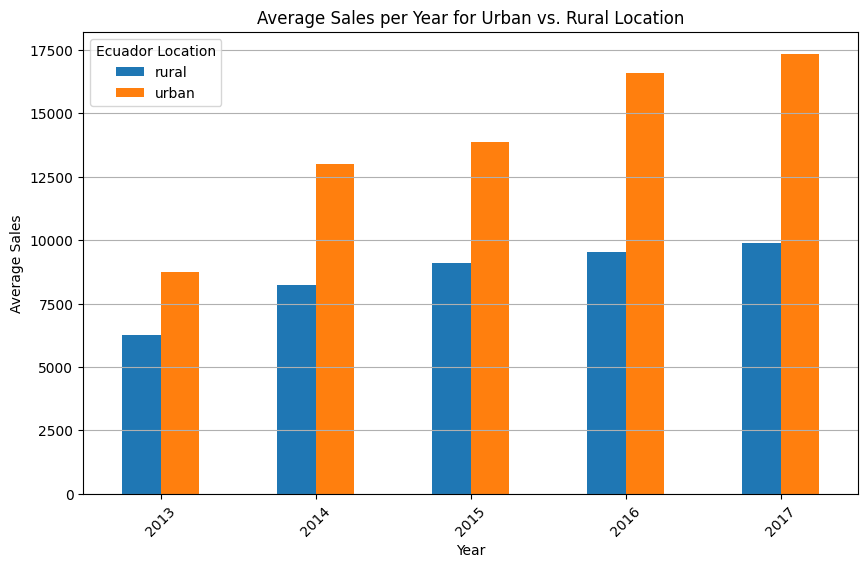

In [ ]:
# Group sales by year and location, and calculate the average sales
sales_by_location = total_df.groupby([total_df['date'].dt.year, 'location'])['sales'].mean().unstack()

# Plot average sales per year for urban/rural locations
sales_by_location.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Urban vs. Rural Location')
plt.legend(title='Ecuador Location')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

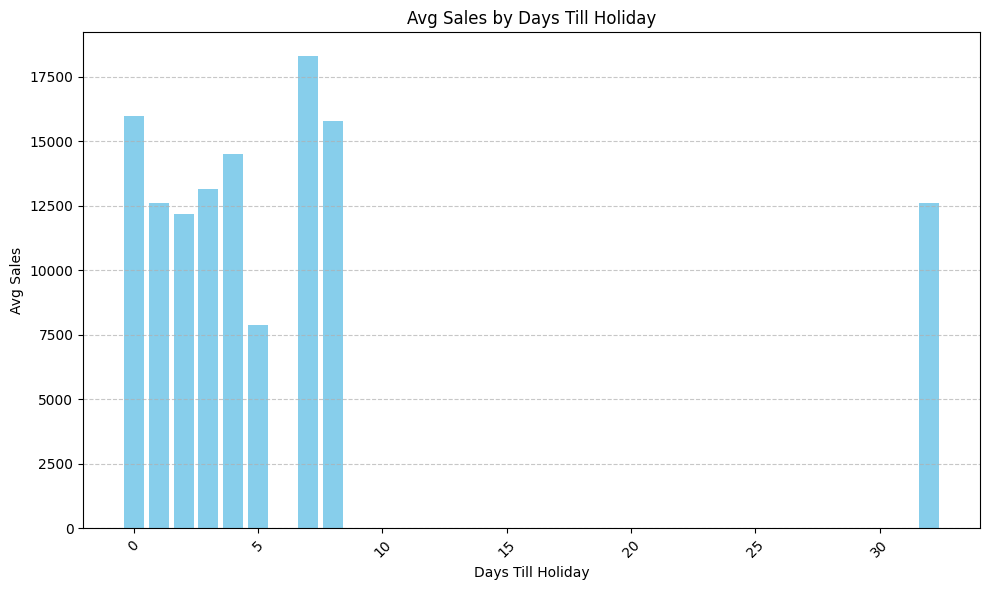

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming total_df is your DataFrame containing sales data
# Grouping sales by days_till_holiday and calculating average sales
avg_sales = total_df.groupby('days_till_holiday')['sales'].mean()

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(avg_sales.index, avg_sales.values, color='skyblue')
plt.xlabel('Days Till Holiday')
plt.ylabel('Avg Sales')
plt.title('Avg Sales by Days Till Holiday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

One Hot Feature Encoding (for categorical variables)

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 83606 entries, (1, 25) to (1684, 9)
Data columns (total 77 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   month                                 83606 non-null  int64  
 1   year                                  83606 non-null  int64  
 2   day_of_month                          83606 non-null  int64  
 3   daily_oil_price                       83606 non-null  float64
 4   transactions                          83606 non-null  float64
 5   days_till_holiday                     83606 non-null  float64
 6   sales                                 83606 non-null  float64
 7   city_altitude                         83606 non-null  float64
 8   ecuador_gdp_growth                    83606 non-null  float64
 9   ecuador_inflation_rate                83606 non-null  float64
 10  ecuador_labor_force                   83606 non-null  int64  
 11  ecuad

In [ ]:
total_df = pd.get_dummies(total_df, columns=['is_holiday','day_of_week','city','state','region','is_coastal','location','ecuador_season','is_2016','is_weekend'])

In [ ]:
# Assuming total_df is your actual DataFrame
total_df = total_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [ ]:
import datetime as dt
# Sort the DataFrame by date
total_df.sort_values(by='date', inplace=True)

# Find unique dates and assign ordinal values
unique_dates = total_df['date'].unique()
ordinal_encoding = {date: i+1 for i, date in enumerate(unique_dates)}

# Apply ordinal encoding to the 'date' column
total_df['date'] = total_df['date'].map(ordinal_encoding)

In [ ]:
total_df.reset_index(drop=True, inplace=True)

In [ ]:
total_df.set_index(['date', 'store_nbr'], inplace=True)

Specify Data Split

In [ ]:
data = total_df.loc[total_df.index.get_level_values('date') <= 1000]

Creating Input Features + Target Variable


In [ ]:
# Extracting features (all columns except 'sales') while preserving MultiIndex
features = data.drop(columns=['sales'])

# Extracting target variable (sales column) while preserving MultiIndex
sales = data[['sales']]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the Data
# Resetting index to split date and store_nbr
features = features.reset_index()
sales = sales.reset_index()

# Extracting features and sales data
model_features = features.drop(columns=['date', 'store_nbr'])
model_sales = sales['sales']

# Standard Scaling the Features
scaler = StandardScaler()
model_features_scaled = scaler.fit_transform(model_features)

Ridge Regression Performance

In [ ]:
from numpy import arange
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

#Run Linear Regression Code for setting up/scaling data

# Train the Ridge Regression Model:
# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)  # Reduce the number of splits and repeats

# Define model with automatic alpha selection and negative mean absolute error as scoring metric
ridge_model = RidgeCV(alphas=arange(0.1, 1, 0.1), cv=cv, scoring='neg_mean_absolute_error')  # Reduce the search space for alpha values

# Fit the model
ridge_model.fit(model_features_scaled, model_sales)

# Predict Sales
ridge_model_sales_pred = ridge_model.predict(model_features_scaled)

# Adding predictions to the DataFrame
features['Ridge Predicted Sales'] = ridge_model_sales_pred

# Step 4: Aggregate Sales by Date
# Grouping by date and summing up sales
ridge_results = features.groupby('date').agg({'Actual Sales': 'sum', 'Ridge Predicted Sales': 'sum'})

In [ ]:
# Summarize chosen configuration
print('Alpha selected by RidgeCV:', ridge_model.alpha_)

Alpha selected by RidgeCV: 0.9


In [ ]:
ridge_results

,Actual Sales,Ridge Predicted Sales
date,,
1,2.511619e+03,1865.668895
2,4.960924e+05,444473.292437
3,3.614612e+05,306573.189551
4,3.544597e+05,316310.494116
5,4.773501e+05,508316.160202
...,...,...
996,6.460839e+05,635910.915714
997,8.904861e+05,792044.015181
998,1.018063e+06,871800.848056


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
ridge_mae = mean_absolute_error(ridge_results['Actual Sales'], ridge_results['Ridge Predicted Sales'])

# Calculate Mean Absolute Percent Error (MAPE)
ridge_mape = (abs(ridge_results['Actual Sales'] - ridge_results['Ridge Predicted Sales']) / ridge_results['Actual Sales']).mean() * 100

print(f"Ridge Mean Absolute Error (MAE): {ridge_mae}")
print(f"Ridge Mean Absolute Percent Error (MAPE): {ridge_mape:.2f}%")

Ridge Mean Absolute Error (MAE): 68285.08343528637
Ridge Mean Absolute Percent Error (MAPE): 12.60%


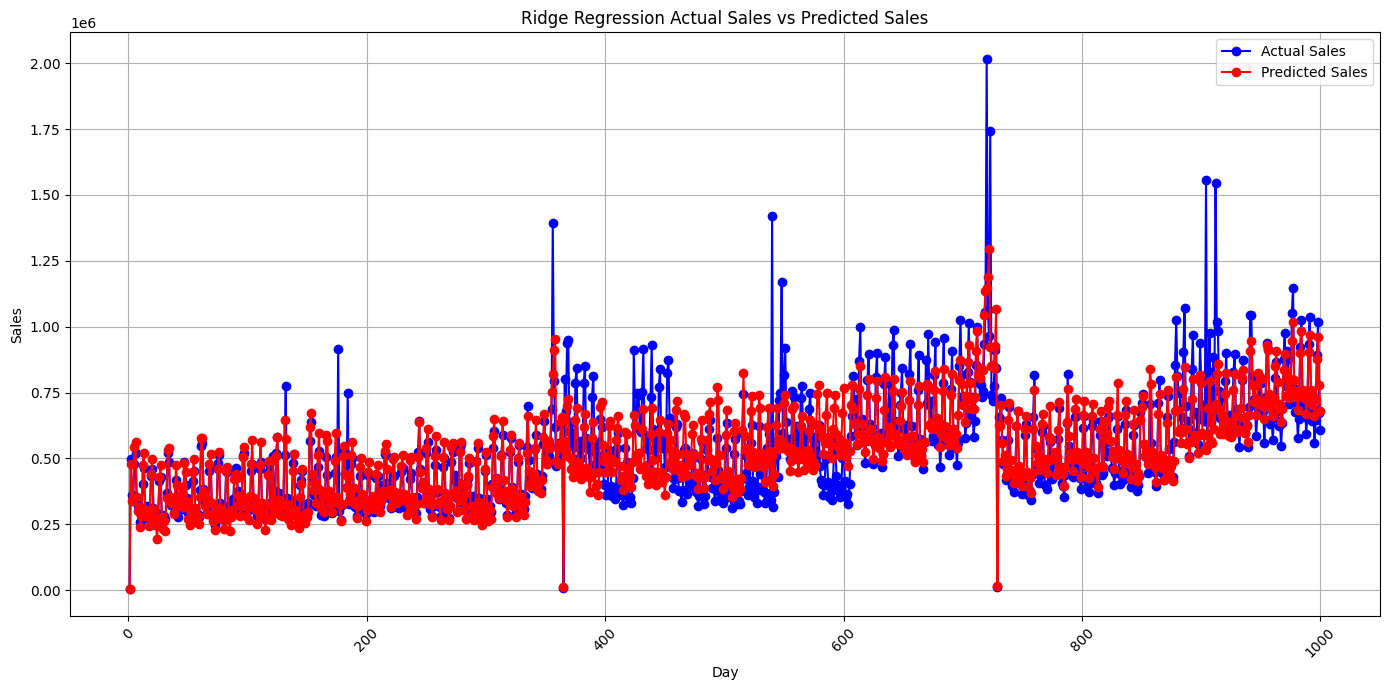

In [ ]:
# Plotting Actual Sales vs Predicted Sales
plt.figure(figsize=(14, 7))
plt.plot(ridge_results.index, ridge_results['Actual Sales'], label='Actual Sales', color='blue', marker='o')
plt.plot(ridge_results.index, ridge_results['Ridge Predicted Sales'], label='Predicted Sales', color='red', marker='o')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Ridge Regression Actual Sales vs Predicted Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Lasso Regression Performance

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.preprocessing import StandardScaler

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define Lasso regression model with automatic alpha selection and L1 regularization
lasso_model = LassoCV(alphas=arange(0.01, 0.1, 0.01), cv=cv, n_jobs=-1, max_iter=10000, eps=1e-5)

# Fit the model
lasso_model.fit(model_features_scaled, model_sales)

# Predict Sales
lasso_model_sales_pred = lasso_model.predict(model_features_scaled)

# Adding predictions to the DataFrame
features['Lasso Predicted Sales'] = lasso_model_sales_pred

# Aggregate Sales by Date
# Grouping by date and summing up sales
lasso_results = features.groupby('date').agg({'Actual Sales': 'sum', 'Lasso Predicted Sales': 'sum'})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87708094601.55963, tolerance: 308543711.2345554
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86595027193.51215, tolerance: 307685638.9199753
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14438183282.879517, tolerance: 308543711.2345554
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWa

In [ ]:
lasso_results

,Actual Sales,Lasso Predicted Sales
date,,
1,2.511619e+03,1865.380821
2,4.960924e+05,444473.962768
3,3.614612e+05,306576.621722
4,3.544597e+05,316315.125724
5,4.773501e+05,508307.391252
...,...,...
996,6.460839e+05,635918.550915
997,8.904861e+05,792042.646458
998,1.018063e+06,871803.904095


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
lasso_mae = mean_absolute_error(lasso_results['Actual Sales'], lasso_results['Lasso Predicted Sales'])

# Calculate Mean Absolute Percent Error (MAPE)
lasso_mape = (abs(lasso_results['Actual Sales'] - lasso_results['Lasso Predicted Sales']) / lasso_results['Actual Sales']).mean() * 100

print(f"Lasso Mean Absolute Error (MAE): {lasso_mae}")
print(f"Lasso Mean Absolute Percent Error (MAPE): {lasso_mape:.2f}%")

Lasso Mean Absolute Error (MAE): 68284.88102479129
Lasso Mean Absolute Percent Error (MAPE): 12.60%


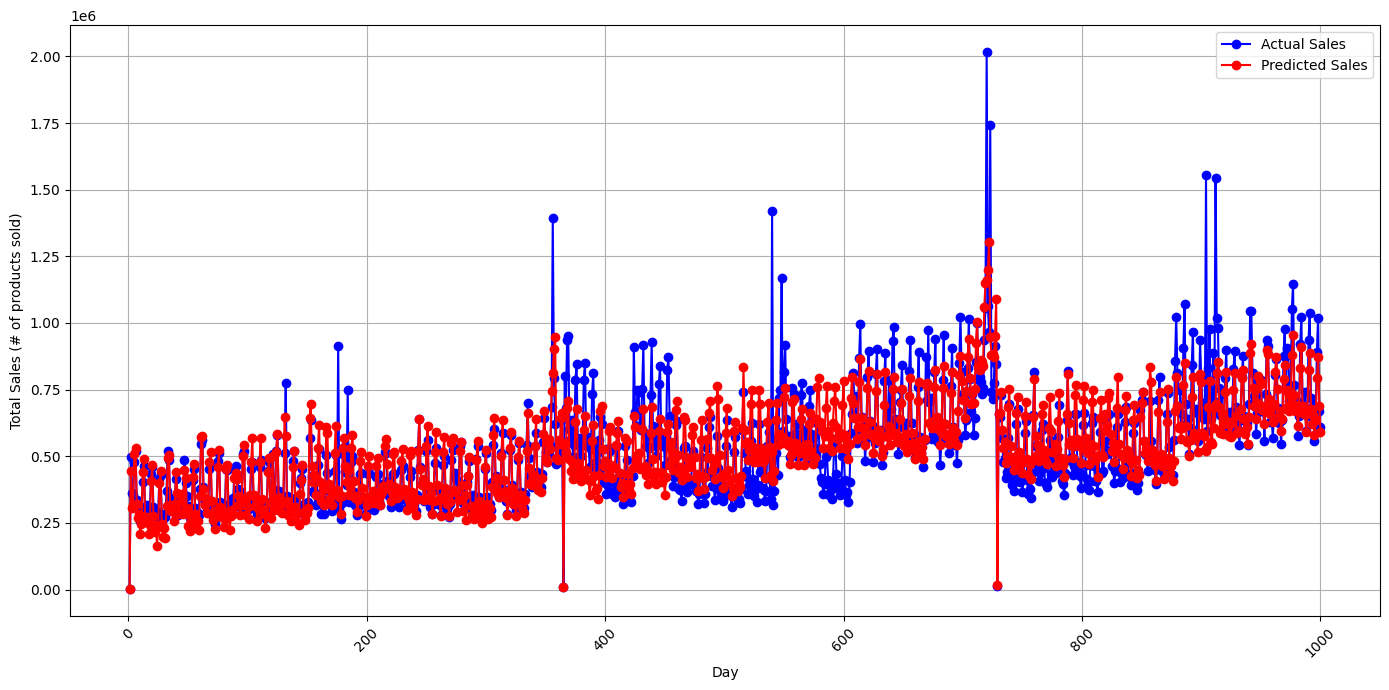

In [ ]:
# Plotting Actual Sales vs Predicted Sales
plt.figure(figsize=(14, 7))
plt.plot(lasso_results.index, lasso_results['Actual Sales'], label='Actual Sales', color='blue', marker='o')
plt.plot(lasso_results.index, lasso_results['Lasso Predicted Sales'], label='Predicted Sales', color='red', marker='o')
plt.xlabel('Day')
plt.ylabel('Total Sales (# of products sold)')
# plt.title('Lasso Regression Actual Sales vs Predicted Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

SHAP Feature Analysis on Lasso Model


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 2: Initialize the StandardScaler
scaler = StandardScaler()

# Step 3: Fit and transform the model features
scaled_features = scaler.fit_transform(model_features)

# Step 4: Convert the scaled array back to a DataFrame
model_features_shap = pd.DataFrame(scaled_features, index=model_features.index, columns=model_features.columns)

model_features_shap


,month,year,day_of_month,daily_oil_price,transactions,days_till_holiday,city_altitude,ecuador_gdp_growth,ecuador_inflation_rate,ecuador_labor_force,...,is_coastal_False,is_coastal_True,location_rural,location_urban,ecuador_season_dry,ecuador_season_rainy,is_2016_False,is_2016_True,is_weekend_False,is_weekend_True
0,-1.565010,-1.165029,-1.681141,0.459430,-0.989487,-1.534617,1.407750,0.892422,-1.285443,-0.941173,...,-1.316943,1.316943,-0.375876,0.375876,0.767966,-0.767966,0.0,0.0,0.869362,-0.869362
1,-1.565010,-1.165029,-1.567009,0.459430,-0.036892,-0.005886,0.547550,0.892422,-1.285443,-0.941173,...,0.759334,-0.759334,-0.375876,0.375876,0.767966,-0.767966,0.0,0.0,0.869362,-0.869362
2,-1.565010,-1.165029,-1.567009,0.459430,0.269262,-0.005886,0.203555,0.892422,-1.285443,-0.941173,...,0.759334,-0.759334,-0.375876,0.375876,0.767966,-0.767966,0.0,0.0,0.869362,-0.869362
3,-1.565010,-1.165029,-1.567009,0.459430,-0.144460,-0.005886,0.547550,0.892422,-1.285443,-0.941173,...,0.759334,-0.759334,-0.375876,0.375876,0.767966,-0.767966,0.0,0.0,0.869362,-0.869362
4,-1.565010,-1.165029,-1.567009,0.459430,0.202033,-0.005886,0.723563,0.892422,-1.285443,-0.941173,...,0.759334,-0.759334,-0.375876,0.375876,0.767966,-0.767966,0.0,0.0,0.869362,-0.869362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47526,0.872343,1.346423,1.514550,-1.691448,-1.148770,-0.005886,1.407750,-1.544410,1.125211,1.523924,...,-1.316943,1.316943,-0.375876,0.375876,-1.302141,1.302141,0.0,0.0,0.869362,-0.869362
47527,0.872343,1.346423,1.514550,-1.691448,0.398550,-0.005886,-1.249340,-1.544410,1.125211,1.523924,...,-1.316943,1.316943,-0.375876,0.375876,-1.302141,1.302141,0.0,0.0,0.869362,-0.869362
47528,0.872343,1.346423,1.514550,-1.691448,-0.827101,-0.005886,0.534450,-1.544410,1.125211,1.523924,...,0.759334,-0.759334,-0.375876,0.375876,-1.302141,1.302141,0.0,0.0,0.869362,-0.869362
47529,0.872343,1.346423,1.514550,-1.691448,-0.712293,-0.005886,-0.818712,-1.544410,1.125211,1.523924,...,0.759334,-0.759334,-0.375876,0.375876,-1.302141,1.302141,0.0,0.0,0.869362,-0.869362


In [ ]:
import shap

# Compute SHAP values
explainer = shap.Explainer(lasso_model, model_features_shap)
shap_values = explainer.shap_values(model_features_shap)

Lasso Model Analysis


In [ ]:
import pandas as pd

# Assuming train_features is the DataFrame containing your features and lasso_model.coef_ is defined

# Get non-zero coefficients and corresponding feature names
non_zero_coef = {feature: coef for feature, coef in zip(model_features_shap.columns, lasso_model.coef_) if coef != 0} # Use model_features.columns here

# Define the desired features in the specified order
desired_features = [
    'ecuador_labor_force', 'city_altitude', 'daily_oil_price', 'day_of_month', 'ecuador_gdp_growth',
    'ecuador_inflation_rate', 'day_of_week_Sunday', 'ecuador_unemployment_rate', 'day_of_week_Saturday',
    'days_till_holiday'
]

# Filter the non-zero coefficients dictionary to include only the desired features
filtered_non_zero_coef = {feature: non_zero_coef[feature] for feature in desired_features if feature in non_zero_coef}

# Create the DataFrame
lasso_analysis = pd.DataFrame({
    'Feature': filtered_non_zero_coef.keys(),
    'Coefficient': filtered_non_zero_coef.values()
})

# Display the DataFrame with only the 'Feature' column
lasso_analysis.index = range(1, len(lasso_analysis) + 1)
lasso_analysis

,Feature,Coefficient
1,ecuador_labor_force,-890.260256
2,city_altitude,-211.696710
3,daily_oil_price,-1953.303703
4,day_of_month,-225.390146
5,ecuador_gdp_growth,2219.119204
6,ecuador_inflation_rate,1180.891792
7,day_of_week_Sunday,815.194861
8,ecuador_unemployment_rate,1032.453362
9,day_of_week_Saturday,184.857054
10,days_till_holiday,-65.556895


Ridge Model Analysis

In [ ]:
import shap
import pandas as pd

# Compute SHAP values using the Ridge model
explainer = shap.Explainer(ridge_model, model_features)
shap_values = explainer.shap_values(model_features)

# Create a DataFrame with SHAP values and features
ridge_shap_df = pd.DataFrame(data=shap_values, columns=model_features.columns)

# Add SHAP value number as a new column
ridge_shap_df['SHAP Value Number'] = range(1, len(ridge_shap_df) + 1)

# Melt the DataFrame to have SHAP values and features in separate rows
ridge_shap_df = ridge_shap_df.melt(id_vars='SHAP Value Number', var_name='Feature', value_name='SHAP Value')

# Filter out entries where the feature is 'transactions' or 'year'
ridge_shap_df_filtered = ridge_shap_df[~ridge_shap_df['Feature'].isin(['transactions', 'year'])]

# Group by feature and calculate the absolute sum of SHAP values
ridge_shap_df_grouped = ridge_shap_df_filtered.groupby('Feature')['SHAP Value'].sum().abs().reset_index()

# Filter out features with zero SHAP values
ridge_shap_df_grouped_nonzero = ridge_shap_df_grouped[ridge_shap_df_grouped['SHAP Value'] != 0]

# Calculate the magnitude of SHAP values
ridge_shap_df_grouped_nonzero['Magnitude'] = ridge_shap_df_grouped_nonzero['SHAP Value'].abs()

# Sort by the magnitude of SHAP values in descending order
ridge_shap_df_grouped_nonzero = ridge_shap_df_grouped_nonzero.sort_values(by='Magnitude', ascending=False)

# Reset index and update index values
ridge_shap_df_grouped_nonzero.index = range(1, len(ridge_shap_df_grouped_nonzero) + 1)

# Drop the magnitude column
ridge_shap_df_grouped_nonzero = ridge_shap_df_grouped_nonzero.drop(columns=['Magnitude'])

# Format SHAP values in scientific notation
ridge_shap_df_grouped_nonzero['SHAP Value'] = ridge_shap_df_grouped_nonzero['SHAP Value'].apply(lambda x: f"{x:.2e}")

# Select only the top 10 SHAP value features
ridge_shap_df_top10 = ridge_shap_df_grouped_nonzero.head(10)

# Display the DataFrame
ridge_shap_df_top10

<ipython-input-89-5a736055f7d6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_shap_df_grouped_nonzero['Magnitude'] = ridge_shap_df_grouped_nonzero['SHAP Value'].abs()


,Feature,SHAP Value
1,ecuador_labor_force,3.23e+12
2,city_altitude,7.96e+08
3,daily_oil_price,5.10e+08
4,ecuador_gdp_growth,2.78e+07
5,day_of_month,1.95e+07
6,month,8.99e+06
7,ecuador_cpi,3.59e+06
8,ecuador_inflation_rate,3.57e+06
9,ecuador_unemployment_rate,1.65e+06
10,day_of_week_Friday,7.71e+05


In [ ]:
import pandas as pd

# Assuming train_features is the DataFrame containing your features and lasso_model.coef_ is defined

# Get non-zero coefficients and corresponding feature names
ridge_non_zero_coef = {feature: coef for feature, coef in zip(model_features.columns, ridge_model.coef_) if coef != 0} # Use model_features.columns here

# Define the desired features in the specified order
ridge_desired_features = [
    'ecuador_labor_force', 'city_altitude', 'daily_oil_price', 'ecuador_gdp_growth', 'day_of_month',
     'month', 'ecuador_cpi', 'ecuador_inflation_rate','ecuador_unemployment_rate','day_of_week_Friday'
]

# Filter the non-zero coefficients dictionary to include only the desired features
ridge_filtered_non_zero_coef = {feature: ridge_non_zero_coef[feature] for feature in ridge_desired_features if feature in ridge_non_zero_coef}

# Create the DataFrame
ridge_analysis = pd.DataFrame({
    'Feature': ridge_filtered_non_zero_coef.keys(),
    'Coefficient': ridge_filtered_non_zero_coef.values()
})

# Display the DataFrame with only the 'Feature' column
ridge_analysis.index = range(1, len(ridge_analysis) + 1)
ridge_analysis

,Feature,Coefficient
1,ecuador_labor_force,-1162.442992
2,city_altitude,-52.921749
3,daily_oil_price,-1953.041692
4,ecuador_gdp_growth,1386.049885
5,day_of_month,-225.405282
6,month,515.780544
7,ecuador_cpi,-125.180748
8,ecuador_inflation_rate,1141.853705
9,ecuador_unemployment_rate,1655.417089
10,day_of_week_Friday,-348.525134
